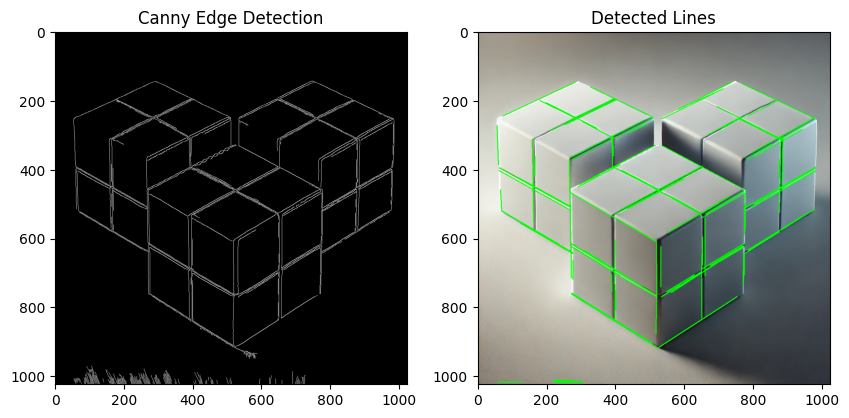

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "cubes.jpg"  
image = cv2.imread(image_path)

# Convert to grayscale and detect edges, using the Canny algorithm
def detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    return edges

# --- Detect lines using Probabilistic Hough Transform ---
def detect_lines(edges):
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
    return lines

# --- Draw lines on image ---
def draw_lines(image, lines):
    output = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = map(int, line[0])
            cv2.line(output, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green lines
    return output


# Process the image
edges = detect_edges(image)
lines = detect_lines(edges)
image_with_lines = draw_lines(image, lines)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")

plt.show()


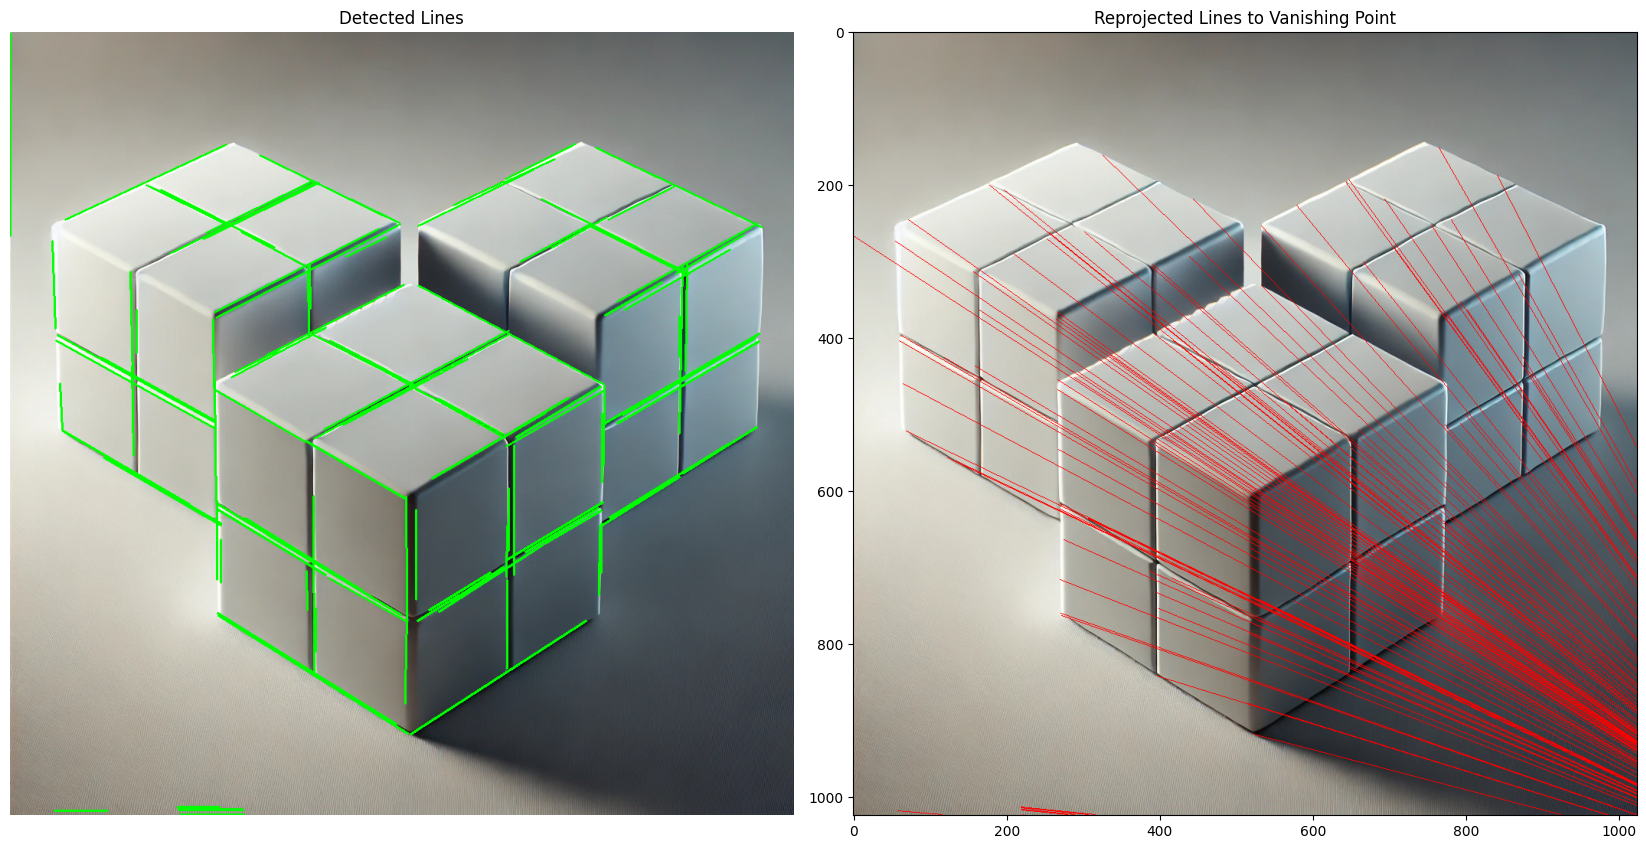

In [40]:
# --- Vanishing Point Detection ---
# --- Compute intersection point of two lines ---
def compute_intersection(line1, line2):
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]

    A1 = y2 - y1
    B1 = x1 - x2
    C1 = A1 * x1 + B1 * y1

    A2 = y4 - y3
    B2 = x3 - x4
    C2 = A2 * x3 + B2 * y3

    determinant = A1 * B2 - A2 * B1
    if determinant == 0:
        return None  # Parallel lines

    x = (B2 * C1 - B1 * C2) / determinant
    y = (A1 * C2 - A2 * C1) / determinant
    return (x, y)

# --- Get vanishing point from multiple line intersections ---
def get_vanishing_point(lines):
    if lines is None or len(lines) < 2:
        return (0, 0)

    points = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            pt = compute_intersection(lines[i], lines[j])
            if pt is not None and all(np.isfinite(pt)):
                points.append(pt)

    if not points:
        return (0, 0)

    points = np.array(points)
    avg_x = np.mean(points[:, 0])
    avg_y = np.mean(points[:, 1])
    return (int(avg_x), int(avg_y))

# --- Reproject all lines toward vanishing point ---
def reproject_lines(image, lines, vanishing_point):
    vp_x, vp_y = map(int, vanishing_point)
    output = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = map(int, line[0])
            cv2.line(output, (x1, y1), (vp_x, vp_y), (0, 0, 255), 1)  # Red reprojected lines
    cv2.circle(output, (vp_x, vp_y), 5, (255, 0, 0), -1)  # Blue dot for VP
    return output

# --- Pipeline Execution ---
edges = detect_edges(image)
lines = detect_lines(edges)
image_with_lines = draw_lines(image, lines)
vanishing_point = get_vanishing_point(lines)
image_with_vp = reproject_lines(image, lines, vanishing_point)

# --- Display all results ---
plt.figure(figsize=(25, 25))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(image_with_vp, cv2.COLOR_BGR2RGB))
plt.title("Reprojected Lines to Vanishing Point")

plt.tight_layout()
plt.show()


noises?

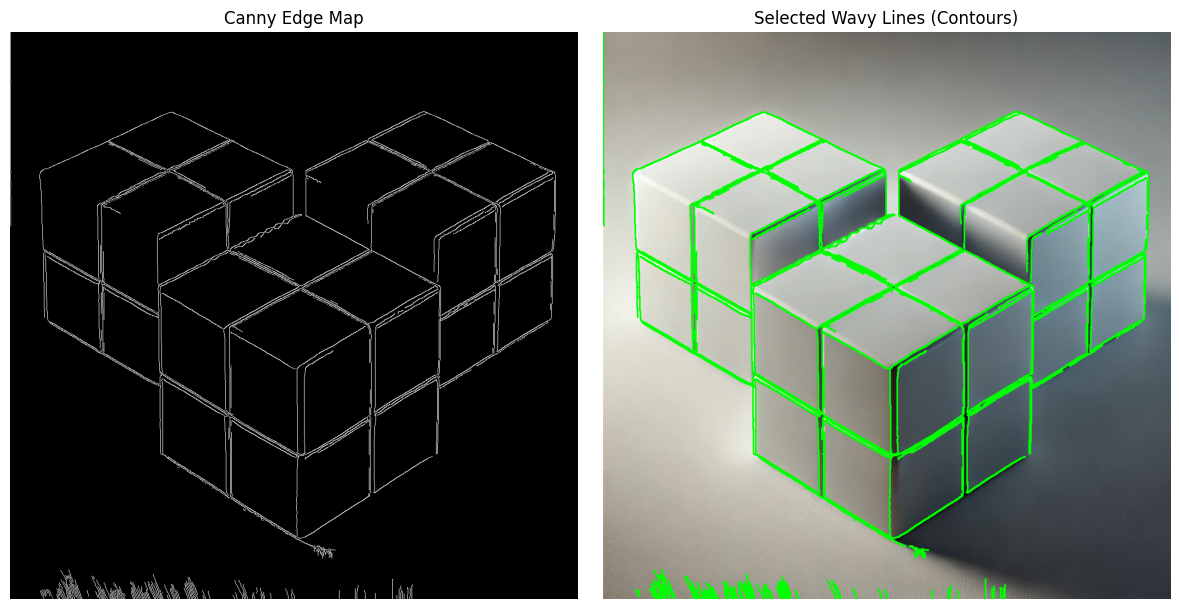

In [26]:


# Load image and Canny edge detection
image_path = "cubes.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)

# Find contours from edges
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

# Function: Measure waviness using arc/chord ratio
def is_wavy(contour, arc_chord_threshold=1.2, min_length=30):
    if len(contour) < min_length:
        return False
    arc_length = cv2.arcLength(contour, False)
    start = contour[0][0]
    end = contour[-1][0]
    chord_length = np.linalg.norm(start - end)
    if chord_length == 0:
        return False
    ratio = arc_length / chord_length
    return ratio > arc_chord_threshold

# Select wavy contours
wavy_contours = [cnt for cnt in contours if is_wavy(cnt)]

# Draw results
output_image = image.copy()
cv2.drawContours(output_image, wavy_contours, -1, (0, 255, 0), 2)


# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Map")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Selected Wavy Lines (Contours)")
plt.axis('off')

plt.tight_layout()
plt.show()


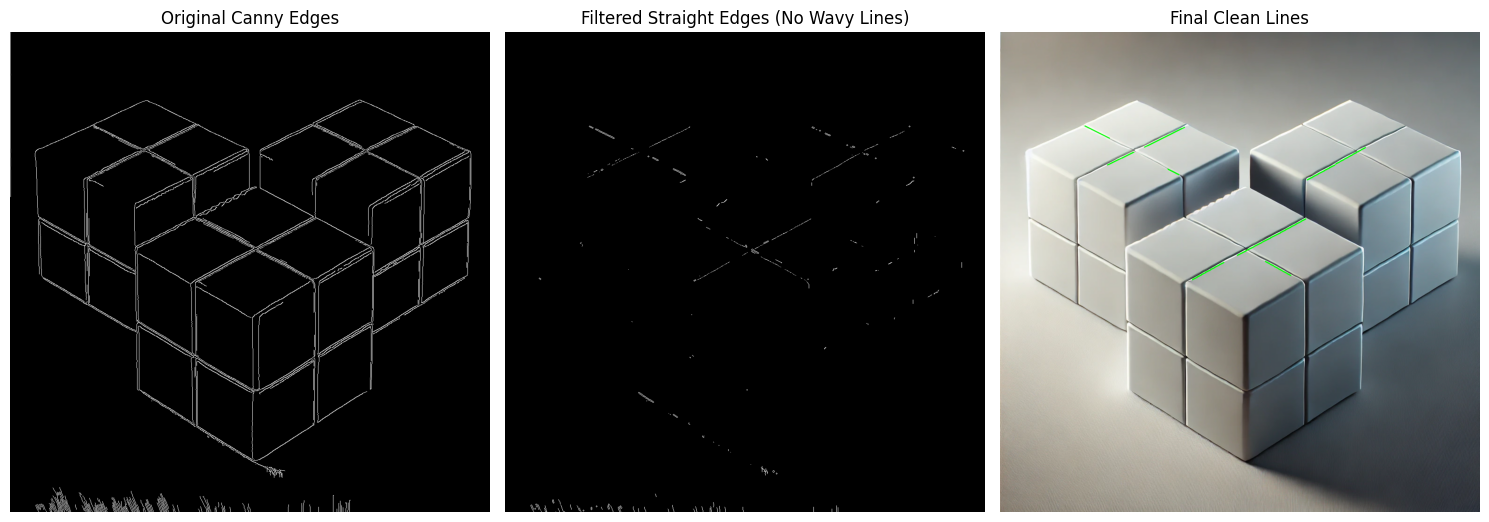

In [27]:

# Step 4: Create a new edge mask without wavy lines
def filter_out_wavy_contours(edges, contours, arc_chord_threshold=1.0):
    mask = np.zeros_like(edges)
    for cnt in contours:
        if not is_wavy(cnt, arc_chord_threshold=arc_chord_threshold):
            cv2.drawContours(mask, [cnt], -1, 255, thickness=1)
    return mask

# Step 5: Filter straight edges only
straight_edges = filter_out_wavy_contours(edges, contours, arc_chord_threshold=1.2)

# Step 6: Optionally apply Hough Transform to see final clean lines
straight_lines = cv2.HoughLinesP(straight_edges, 1, np.pi/180, threshold=40,
                                minLineLength=20, maxLineGap=10)

# Draw straight lines on the image
output_image = image.copy()
if straight_lines is not None:
    for line in straight_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)




# Step 7: Plotting results
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(edges, cmap='gray')
plt.title("Original Canny Edges")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(straight_edges, cmap='gray')
plt.title("Filtered Straight Edges (No Wavy Lines)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Final Clean Lines")
plt.axis('off')

plt.tight_layout()
plt.show()


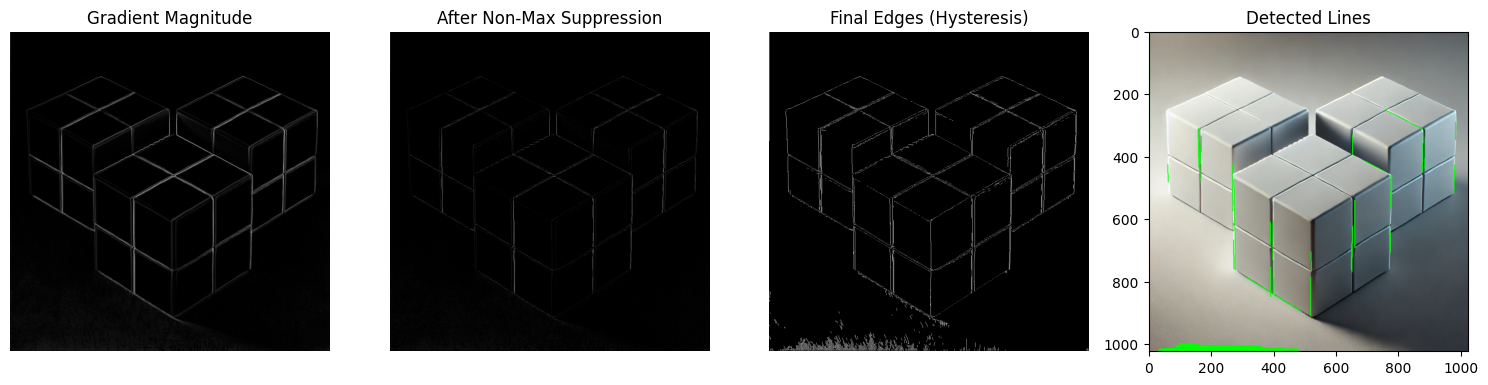

In [35]:

# --- Load image ---
image_path = "cubes.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# --- Compute gradients using Sobel ---
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
gradient_direction = np.arctan2(sobel_y, sobel_x)

# --- Non-Maximum Suppression ---
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    M, N = gradient_magnitude.shape
    suppressed = np.zeros((M, N), dtype=np.float32)
    angle = gradient_direction * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            try:
                q = r = 255
                # 0 degrees
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = gradient_magnitude[i, j+1]
                    r = gradient_magnitude[i, j-1]
                # 45 degrees
                elif (22.5 <= angle[i,j] < 67.5):
                    q = gradient_magnitude[i+1, j-1]
                    r = gradient_magnitude[i-1, j+1]
                # 90 degrees
                elif (67.5 <= angle[i,j] < 112.5):
                    q = gradient_magnitude[i+1, j]
                    r = gradient_magnitude[i-1, j]
                # 135 degrees
                elif (112.5 <= angle[i,j] < 157.5):
                    q = gradient_magnitude[i-1, j-1]
                    r = gradient_magnitude[i+1, j+1]

                if (gradient_magnitude[i,j] >= q) and (gradient_magnitude[i,j] >= r):
                    suppressed[i,j] = gradient_magnitude[i,j]
                else:
                    suppressed[i,j] = 0
            except IndexError:
                pass

    return suppressed

# --- Hysteresis Thresholding ---
def hysteresis_thresholding(image, low_thresh, high_thresh):
    M, N = image.shape
    strong = 255
    weak = 75

    result = np.zeros((M, N), dtype=np.uint8)

    strong_i, strong_j = np.where(image >= high_thresh)
    weak_i, weak_j = np.where((image >= low_thresh) & (image < high_thresh))

    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak

    for i in range(1, M-1):
        for j in range(1, N-1):
            if result[i, j] == weak:
                # If any neighbor is strong, upgrade to strong
                if np.any(result[i-1:i+2, j-1:j+2] == strong):
                    result[i, j] = strong
                else:
                    result[i, j] = 0
    return result

# --- Apply NMS and Hysteresis ---
suppressed = non_maximum_suppression(gradient_magnitude, gradient_direction)
edges = hysteresis_thresholding(suppressed, low_thresh=50, high_thresh=100)
lines = detect_lines(edges)
image_with_lines = draw_lines(image, lines)

# --- Visualization ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title("Gradient Magnitude")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(suppressed, cmap='gray')
plt.title("After Non-Max Suppression")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(edges, cmap='gray')
plt.title("Final Edges (Hysteresis)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title("Detected Lines")

plt.tight_layout()
plt.show()
